# Abstract
#### Setting

        1. 채널별로 데이터 저장
        2. 군집화
        3. 시각화

#### Method
        


#### Result

                        


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv('../Processing/data/QTONE_data_YYC_002.csv')

In [42]:
##채널별로 저장

channel_name = df['채널명'].unique().tolist()
for chat_name in channel_name :
    chat_csv = None
    chat_csv = df[df['채널명'] == chat_name]
    chat_csv.to_csv('../Processing/data/Type_A/'+str(chat_name)+'.csv', index=False)

In [46]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler


# 모델 재현성을 위해 난수 시드설정
tf.random.set_seed(777)
np.random.seed(777)

# 데이터 전처리 - 하이퍼 파라미터
# df_AXN['날짜'] = df_AXN['날짜'].dt.strftime("%Y%m%d").astype(int)
# df_AXN['시간'] = df_AXN['시간'].dt.strftime("%H%M%S").astype(int)
window_size = 10
batch_size = 8
features = ['서비스ID', 'Date', 'Time']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)


# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])


# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])


hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=2, 
          callbacks=[checkpoint, early_stop])
          

model.load_weights(checkpoint_path)
# <tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7fa7e4312910>

(8, 10, 3)
(8, 3)
Epoch 1/2
70863/70864 [============================>.] - ETA: 0s - loss: 0.2417 - mae: 0.2417
Epoch 00001: val_loss improved from inf to 0.23517, saving model to /home/innerwave/aiffel/anomaly_detection/kospi/mymodel.ckpt
70864/70864 [==============================] - 1269s 18ms/step - loss: 0.2417 - mae: 0.2417 - val_loss: 0.2352 - val_mae: 0.2352
Epoch 2/2
70863/70864 [============================>.] - ETA: 0s - loss: 0.2307 - mae: 0.2307
Epoch 00002: val_loss improved from 0.23517 to 0.23002, saving model to /home/innerwave/aiffel/anomaly_detection/kospi/mymodel.ckpt
70864/70864 [==============================] - 1267s 18ms/step - loss: 0.2307 - mae: 0.2307 - val_loss: 0.2300 - val_mae: 0.2300


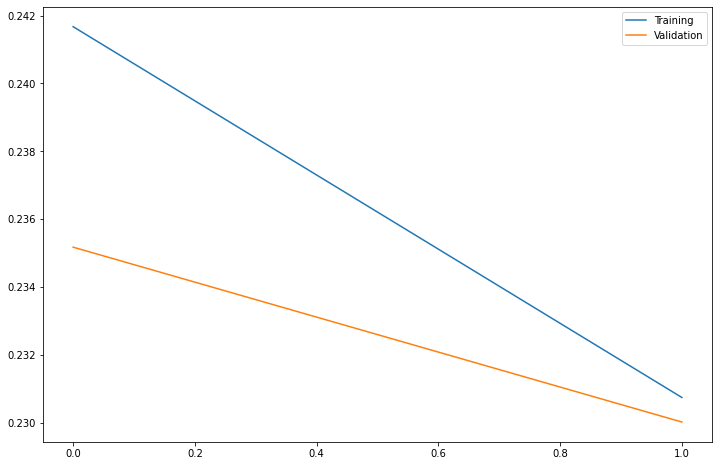

In [47]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

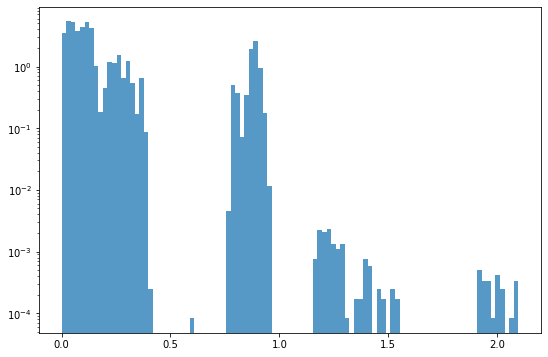

In [48]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [59]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss
threshold = 2
print(len(test_df.loc[test_df.Loss>threshold]))
test_df.loc[test_df.Loss>threshold]

10


,삽입날짜,삽입시간,광고타입,큐톤ID,서비스ID,채널명,OTV 채널번호,OTS 채널번호,서버 타입,Time,Date,Loss
11095,2021-10-05,00:00:02,A,300,714,MBC M,137,137,M,2,20211005,2.002023
92511,2021-11-01,00:00:03,A,241,728,JTBC4,75,75,M,3,20211101,2.026561
117864,2021-11-10,00:00:01,A,123,727,브레인TV,126,142,M,1,20211110,2.026842
137394,2021-11-17,00:00:01,A,403,717,JTBC GOLF&SPORTS,61,61,M,1,20211117,2.005943
278666,2022-01-07,00:00:04,B,923,736,trendy,147,147,M,4,20220107,2.097904
392908,2022-02-15,00:00:00,A,241,728,JTBC4,75,75,M,0,20220215,2.071468
419096,2022-02-24,00:00:00,B,923,736,trendy,147,147,M,0,20220224,2.089179
519372,2022-03-30,00:00:01,A,117,715,MBC SPORTS+,60,104,M,1,20220330,2.034621
522341,2022-03-31,00:00:01,B,923,736,trendy,147,147,M,1,20220331,2.081275
564010,2022-04-14,00:00:00,B,923,736,trendy,147,147,M,0,20220414,2.080129


In [60]:
import pickle

# save
with open('data.pickle', 'wb') as f:
    pickle.dump(test_df['Loss'], f, pickle.HIGHEST_PROTOCOL)

In [ ]:
fig = plt.figure(figsize=(30,15))

<Figure size 2160x1080 with 0 Axes>